# Importation des dépendances

Ce projet utilise l'accélération GPU(NVIDIA) avec "torch" pour de meilleur résultat ainsi qu'une meilleure rapidité

In [83]:
%pip install torch torchvision
import os                                               # manipulation de fichiers et dossiers
import numpy as np                                      # manipulation de tableaux 
import matplotlib.pyplot as plt                         # affichage d'images
from torchvision import datasets, transforms, models    # importation de la base de données et des modèles
import torch                                            # manipulation de tenseurs (tableaux multi-dimensionnels) sur GPU
import torch.nn as nn                                   # construction de réseaux de neurones (nn = neural networks)
import torch.optim as optim                             # optimiseurs (descente de gradient, etc.)
import torch.nn.functional as F                         # fonctions utiles (comme ReLU = Rectified Linear Unit)
from torch.utils.data import DataLoader                 # chargement de données (pour entraînement et test)
from PIL import Image                                   # manipulation d'images 


Note: you may need to restart the kernel to use updated packages.


Utilisation du GPU si disponible (nécéssite l'installation de CUDA pour les carte graphique NVIDIA ou l'utilisation de anaconda avec le plugin CUDA)

In [84]:
if torch.cuda.is_available():
    print("CUDA est disponible. Nombre de GPU disponibles :", torch.cuda.device_count())
    print("Nom du GPU :", torch.cuda.get_device_name(0))
    device = torch.device("cuda")       # utilisation du GPU
else:
    print("CUDA n'est pas disponible.")
    device = torch.device("cpu")        # utilisation du CPU

CUDA est disponible. Nombre de GPU disponibles : 1
Nom du GPU : NVIDIA GeForce RTX 4070 SUPER


# Déclaration des dossiers d'entrainement et de test

Ces 2 dossiers contiennent des images de pions de jeu d'échecs, les images sont différentes entre le dossier "/Train" et "/Test"
<br />
Le but est que les images soient différentes pour vérifier si le modèle a bien appris

In [85]:
base_dir = os.path.abspath('./ChessDataset')        # répertoire contenant les données
train_dir = os.path.join(base_dir, 'Train')         # répertoire contenant les données d'entraînement
test_dir = os.path.join(base_dir, 'Test')           # répertoire contenant les données de test

# Déclaration des varibles pour la configuration de l'entrainement

In [86]:
lr = 0.0001              # Taux d'apprentissage (learning rate)
batch_size = 32         # Taille du batch (nombre d'images traitées en même temps)
num_epochs = 30         # Nombre d'epochs (nombre de fois que le modèle va voir toutes les données)
num_images = 15         # Nombre d'images à afficher pour la démonstration

## Transformations des données

Pour préparer les images d'entraînement et de validation, j'applique une série de transformations à l'aide de `torchvision.transforms`. <br /> Ces transformations permettent de normaliser les images et d'augmenter les données d'entraînement pour améliorer la robustesse du modèle.

## Transformations pour l'entraînement

Les transformations suivantes sont appliquées aux images d'entraînement :


In [87]:
# Configuration de la transformation des images d'entraînement
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),                                                  # Redimensionne l'image en 150x150 (accelère l'entraînement)
    transforms.RandomHorizontalFlip(),                                              # Retourne horizontalement l'image aléatoirement
    transforms.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2)),                # Applique une transformation affine aléatoire (cisaillement et échelle)
    transforms.ToTensor(),                                                          # Convertit l'image en tenseur (tableau multidimensionnel PyTorch)                                             
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # Normalise les couleurs de l'image (RVB) pour accélérer l'entraînement
])

# Configuration de la transformation des images de validation (adaptée pour des données réelles non modifiées)
validation_transform = transforms.Compose([
    transforms.Resize((150, 150)),                                                  # Redimensionne l'image en 150x150
    transforms.ToTensor(),                                                          # Convertit l'image en tenseur (tableau multidimensionnel PyTorch)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # Normalise les couleurs de l'image (RVB) (accélérer l'entraînement)
])

## Chargement des ensembles de données et création des DataLoader

Pour charger les ensembles de données d'entraînement et de validation, j'utilise `datasets.ImageFolder` de `torchvision`. Les transformations définies précédemment sont appliquées aux images lors du chargement.

### Explication des couches du modèle pour réseaux de neurones convolutifs (CNN)

1. **`Conv2d`**: Extrait des caractéristiques locales des images de + en + complexe en appliquant des filtres convolutifs. **3 couches convolutive :**
    - 1 : Détecte des caractéristiques simples telles que les bords, les lignes et les textures de base <br /> **(Exemple : Détection des contours des pièces d'échecs)**
    - 2 : Détecte des caractéristiques simples détectées par la première couche et les combine pour détecter des motifs plus complexes Détection des formes et des motifs plus complexes des pièces d'échecs <br /> **(Exemple : Détection des formes et des motifs plus complexes des pièces d'échecs)**
    - 3 : Détecte des caractéristiques complexes détectées par la deuxième couche et les combine pour détecter des motifs encore plus abstraits et de haut niveau <br /> **(Exemple : Détection des pièces d'échecs entières et de leurs relations spatiales)**
2. **`MaxPool2d`** : Réduit les dimensions spatiales des cartes (HxW pour les images) de caractéristiques en sélectionnant les valeurs maximales dans des sous-régions.
3. **`Linear`** : Effectue des transformations linéaires sur les données d'entrée et est généralement utilisée pour la classification ou la régression après les couches convolutives et de pooling.



In [88]:
# Charger les ensembles de données d'entraînement et de validation
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)              # Images dans le répertoire d'entraînement
validation_dataset = datasets.ImageFolder(test_dir, transform=validation_transform)     # Images dans le répertoire de test

# Créer des DataLoader pour les ensembles de données
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)                      # DataLoader pour l'ensemble de données d'entraînement
validation_loader = DataLoader(validation_dataset, batch_size, shuffle=False)           # DataLoader pour l'ensemble de données de validation

# Définir le modèle
class ChessModel(nn.Module):
    # Définit la structure du modèle
    def __init__(self, num_classes):
        super(ChessModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)                         # CNN 2D -> 3 canaux d'entrée(RGB)                 | 32 canaux de sortie  | un noyau de taille 3x3 | padding de 1px (pour delimiter les bords)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)                        # CNN 2D -> 32 canaux d'entrée(sortie précédentes) | 64 canaux de sortie  | un noyau de taille 3x3 | padding de 1px (pour delimiter les bords)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)                       # CNN 2D -> 64 canaux d'entrée(sortie précédentes) | 128 canaux de sortie | un noyau de taille 3x3 | padding de 1px (pour delimiter les bords)
        # Possibilité d'ajouter plus de couches de convolution pour augmenter la complexité du modèle
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                               # Division l'image en régions de 2x2 et ne garde que la valeur maximale de chaque région (catégorisation)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)                                        # Combine les données en une seule couche linéaire avec 128*18*18 entrées et 512 sorties
        self.dropout = nn.Dropout(0.5)                                                  # Dropout de 50% pour éviter le surapprentissage
        self.fc2 = nn.Linear(512, num_classes)                                          # Couche linéaire finale avec 512 entrées et le nombre de classes en sortie

    # Définit la propagation avant du modèle
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                                            # Applique la fonction d'activation ReLU à la sortie de la première couche de convolution, puis la met en commun
        x = self.pool(F.relu(self.conv2(x)))                                            # Applique la fonction d'activation ReLU à la sortie de la deuxième couche de convolution, puis la met en commun
        x = self.pool(F.relu(self.conv3(x)))                                            # Applique la fonction d'activation ReLU à la sortie de la troisième couche de convolution, puis la met en commun
        x = x.view(-1, 128 * 18 * 18)                                                   # Aplatit les données pour les passer à la couche linéaire
        x = F.relu(self.fc1(x))                                                         # Applique la fonction d'activation ReLU à la sortie de la première couche lin
        x = self.dropout(x)                                                             # Applique le dropout
        x = self.fc2(x)                                                                 # Passe la sortie de la première couche linéaire à la deuxième couche linéaire
        return x

## Création d'une instance du model

In [89]:
num_classes = len(train_dataset.classes)        # Nombre de classes (types de pièces d'échecs donc 6)
model = ChessModel(num_classes).to(device)      # Créer une instance du model et l'envoyer sur le GPU si disponible

## Définir la fonction de perte et l'optimiseur
Utiliser l'optimizer adéquat :

- **Adam** `(Notre Choix)` :
  - Avantage : Combine les avantages de deux autres méthodes d'optimisation (AdaGrad et RMSProp) pour une meilleure.
  - Inconvénient : Peut nécessiter un réglage fin des hyperparamètres.

- **SGD (Stochastic Gradient Descent)** :
  - Avantage : Simple et efficace pour les problèmes convexes.
  - Inconvénient : Peut être lent à converger et sensible au choix du taux d'apprentissage.

- **SGD avec momentum** :
  - Avantage : Accélère la convergence en direction des gradients pertinents.
  - Inconvénient : Nécessite un réglage supplémentaire du paramètre de momentum.

- **RMSprop** :
  - Avantage : Adapte le taux d'apprentissage en fonction de la moyenne mobile des carrés des gradients.
  - Inconvénient : Peut nécessiter un réglage fin des hyperparamètres.

- **Adagrad (Adaptive Gradient Algorithm)** :
  - Avantage : Adapte le taux d'apprentissage pour chaque paramètre.
  - Inconvénient : Le taux d'apprentissage peut devenir très petit au fil du temps.

- **Adadelta** :
  - Avantage : Réduit le taux de déclin rapide du taux d'apprentissage d'Adagrad.
  - Inconvénient : Moins utilisé et peut nécessiter un réglage fin.

- **Nesterov Accelerated Gradient (NAG)** :
  - Avantage : Regarde en avant pour ajuster les gradients, ce qui peut accélérer la convergence.
  - Inconvénient : Nécessite un réglage supplémentaire du paramètre de momentum.

- **LBFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno)** :
  - Avantage : Optimiseur quasi-Newtonien efficace pour les petits ensembles de données.
  - Inconvénient : Moins adapté aux grands ensembles de données et aux réseaux de neurones profonds.


In [90]:
criterion = nn.CrossEntropyLoss()               # Fonction de perte (cross-entropy loss)
optimizer = optim.Adam(model.parameters(), lr)  # Optimiseur (Adam)

# Entrainement du modèle

Entraîne le ChessModel pendant X époques en utilisant les générateurs de données pour fournir les lots d'entraînement et de validation
<br />
À chaque époque, une évaluation est effectuée sur un ensemble de données de validation pour vérifier si l'accuracy sur les données d'entraînement est comparable à celle sur les données de validation.
<br />
De plus, je me sers des noms de dossiers pour définir le nom des pions

In [91]:
# Entraîner le modèle
for epoch in range(num_epochs):
    model.train()                                                                                           # Mettre le modèle en mode entraînement
    running_loss = 0.0                                                                                      # Perte courante                                      
    correct_train = 0                                                                                       # Nombre de prédictions correctes sur l'ensemble d'entraînement
    total_train = 0                                                                                         # Nombre total d'images dans l'ensemble d'entraînement
    for inputs, labels in train_loader:                                                                     # Parcours de l'ensemble d'entraînement
        inputs, labels = inputs.to(device), labels.to(device)                                               # Envoyer les données sur le GPU si disponible
        optimizer.zero_grad()                                                                               # Réinitialiser les gradients
        outputs = model(inputs)                                                                             # Prédire les sorties
        loss = criterion(outputs, labels)                                                                   # Calculer la perte
        loss.backward()                                                                                     # Rétropropagation
        optimizer.step()                                                                                    # Mise à jour des poids
        running_loss += loss.item() * inputs.size(0)                                                        # Mise à jour de la perte
        
        _, predicted = torch.max(outputs, 1)                                                                # Prédire les classes
        total_train += labels.size(0)                                                                       # Mise à jour du nombre total d'images
        correct_train += (predicted == labels).sum().item()                                                 # Mise à jour du nombre de prédictions correctes
    
    epoch_loss = running_loss / len(train_loader.dataset)                                                   # Perte moyenne
    train_accuracy = correct_train / total_train                                                            # Précision moyenne
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')    # Affichage des résultats

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Validation du modèle
    model.eval()                                                                                            # Mettre le modèle en mode évaluation
    val_running_loss = 0.0                                                                                  # Perte courante
    correct_val = 0                                                                                         # Nombre de prédictions correctes sur l'ensemble de validation
    total_val = 0                                                                                           # Nombre total d'images dans l'ensemble de validation
    with torch.no_grad():                                                                                  # Pas de calcul de gradients
        for inputs, labels in validation_loader:                                                            # Parcours de l'ensemble de validation
            inputs, labels = inputs.to(device), labels.to(device)                                           # Envoyer les données sur le GPU si disponible
            outputs = model(inputs)                                                                         # Prédire les sorties
            loss = criterion(outputs, labels)                                                               # Calculer la perte
            val_running_loss += loss.item() * inputs.size(0)                                                # Mise à jour de la perte
            
            _, predicted = torch.max(outputs, 1)                                                            # Prédire les classes
            total_val += labels.size(0)                                                                     # Mise à jour du nombre total d'images
            correct_val += (predicted == labels).sum().item()                                               # Mise à jour du nombre de prédictions correctes
    
    val_loss = val_running_loss / len(validation_loader.dataset)                                            # Perte moyenne
    val_accuracy = correct_val / total_val                                                                  # Précision moyenne
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')                      # Affichage des résultats


Epoch 1/30, Loss: 1.8021, Train Accuracy: 0.1739
Validation Loss: 1.7524, Validation Accuracy: 0.2495
Epoch 2/30, Loss: 1.7719, Train Accuracy: 0.2101
Validation Loss: 1.7444, Validation Accuracy: 0.3636
Epoch 3/30, Loss: 1.7456, Train Accuracy: 0.2609
Validation Loss: 1.7239, Validation Accuracy: 0.3656
Epoch 4/30, Loss: 1.7030, Train Accuracy: 0.3116
Validation Loss: 1.6337, Validation Accuracy: 0.5261
Epoch 5/30, Loss: 1.6585, Train Accuracy: 0.3043
Validation Loss: 1.7096, Validation Accuracy: 0.1721
Epoch 6/30, Loss: 1.5907, Train Accuracy: 0.3659
Validation Loss: 1.6674, Validation Accuracy: 0.3114
Epoch 7/30, Loss: 1.5617, Train Accuracy: 0.3877
Validation Loss: 1.7314, Validation Accuracy: 0.2108
Epoch 8/30, Loss: 1.5295, Train Accuracy: 0.3895
Validation Loss: 1.6091, Validation Accuracy: 0.5126
Epoch 9/30, Loss: 1.4929, Train Accuracy: 0.3986
Validation Loss: 1.7190, Validation Accuracy: 0.2495
Epoch 10/30, Loss: 1.4483, Train Accuracy: 0.4728
Validation Loss: 1.6818, Validat

On remarque pendant l'entrainement que le model a plus d'accuracy sur les données de train que les données de test *(alors qu'en soit c'est le même model avec des données différentes)*

In [92]:
# Sauvegarder le modèle
torch.save(model.state_dict(), 'chess_piece_classifier.pth')

# Evaluer le model pour définir son accuracy final

In [93]:
# Évaluer le modèle
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.3385


In [94]:
model.load_state_dict(torch.load('chess_piece_classifier.pth'))

<All keys matched successfully>

# Démo de ChessModel avec des données de test 

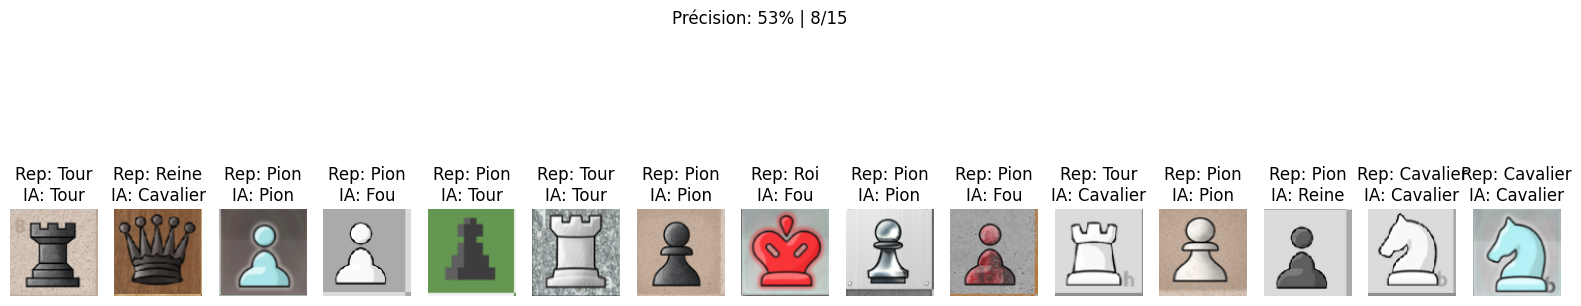

In [95]:
# Fonction pour afficher les images et les prédictions
def display_predictions(model, test_dir, class_indices, num_images):
    class_labels = {v: k for k, v in class_indices.items()}
    test_images = []
    test_labels = []
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                test_images.append(img_path)
                test_labels.append(class_name)

    indices = np.random.choice(len(test_images), num_images, replace=False)
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    correct_predictions = 0
    for ax, i in zip(axes, indices):
        img_path = test_images[i]
        true_label = test_labels[i]
        img = Image.open(img_path)  # Utiliser PIL pour ouvrir l'image
        img_tensor = validation_transform(img).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            prediction = model(img_tensor)
            predicted_label = class_labels[torch.argmax(prediction).item()]

        if predicted_label == true_label:
            correct_predictions += 1

        ax.imshow(img)
        ax.set_title(f"Rep: {true_label}\nIA: {predicted_label}")
        ax.axis('off')

    accuracy = ((correct_predictions / num_images) * 100)
    plt.suptitle(f"Précision: {accuracy:.0f}% | {correct_predictions}/{num_images}")
    plt.show()

# Afficher les prédictions pour quelques images de test
display_predictions(model, test_dir, train_dataset.class_to_idx, num_images)